In [ ]:
# -------------------------
# Final circuit for U block encoding
# --------------------------


Processed target amplitudes: [0.1714883  0.21691745 0.1533838  0.13283427 0.10845873 0.21691745]
Solved rotation angles: [ 5.27069074e+01  1.26610350e+00  2.40675099e+04  1.80366428e+00
 -1.74221073e+01]

Preparation circuit:
     ┌────────────┐                                                        
q_0: ┤ Ry(52.707) ├──────o─────────────■────────────o──────────────o───────
     └────────────┘┌─────┴──────┐┌─────┴─────┐      │              │       
q_1: ──────────────┤ Ry(1.2661) ├┤ Ry(24068) ├──────o──────────────■───────
                   └────────────┘└───────────┘┌─────┴──────┐┌──────┴──────┐
q_2: ─────────────────────────────────────────┤ Ry(1.8037) ├┤ Ry(-17.422) ├
                                              └────────────┘└─────────────┘

Inverse Preparation circuit:
                                                               ┌─────────────┐
q_0: ──────o──────────────o─────────────■──────────────o───────┤ Ry(-52.707) ├
           │              │       ┌─────┴──────┐┌─────

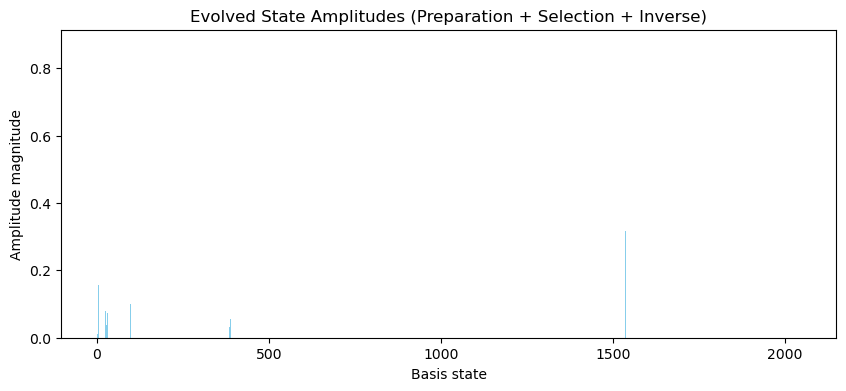

In [1]:
import numpy as np
import math
from scipy.optimize import fsolve
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, XGate, YGate, ZGate, IGate
import itertools
import matplotlib.pyplot as plt

# -------------------------------------------------
# Pad target to next power of 2
# -------------------------------------------------
def pad_target(target):
    N = math.ceil(np.log2(len(target)))
    padded = np.zeros(2**N)
    padded[:len(target)] = target
    return padded, N

# -------------------------------------------------
# Preprocess target into normalized amplitudes
# -------------------------------------------------
def preprocess_target(target):
    total = np.sum(target)
    if total == 0:
        raise ValueError("Target sum is zero")
    betas = np.array([math.sqrt(abs(a) / total) for a in target])
    return betas / np.sum(betas)

# -------------------------------------------------
# Binary-tree amplitudes (limited rotation gates)
# -------------------------------------------------
def psiN_state(theta_vals, N):
    amplitudes = []
    num_amplitudes = 2**N
    for basis_index in range(num_amplitudes):
        binary_path = bin(basis_index)[2:].zfill(N)
        term = 1.0
        node_index = 0
        for bit in binary_path:
            if node_index >= len(theta_vals):
                break
            if bit == "0":
                term *= math.cos(theta_vals[node_index] / 2)
                node_index = 2*node_index + 1
            else:
                term *= math.sin(theta_vals[node_index] / 2)
                node_index = 2*node_index + 2
        amplitudes.append(term)
    return np.array(amplitudes)

# -------------------------------------------------
# System of equations to solve for theta_vals
# -------------------------------------------------
def equations(theta_vals, target):
    psi = psiN_state(theta_vals, math.ceil(np.log2(len(target))))
    return [abs(psi[i]) - abs(target[i]) for i in range(len(target) - 1)]

# -------------------------------------------------
# Preparation circuit with limited rotations
# -------------------------------------------------
def tree_state_prep(theta_vals, target):
    padded_target, N = pad_target(target)
    num_gates_needed = len(target) - 1
    qc = QuantumCircuit(N, name="Preparation")
    node_index = 0

    for target_qubit in range(N):
        for pattern in itertools.product([0, 1], repeat=target_qubit):
            if node_index >= num_gates_needed:
                break
            angle = float(theta_vals[node_index])
            node_index += 1
            if target_qubit == 0:
                qc.ry(angle, target_qubit)
            else:
                ctrl_qubits = list(range(target_qubit-1, -1, -1))
                ctrl_state = "".join(map(str, pattern))
                cry = RYGate(angle).control(num_ctrl_qubits=target_qubit, ctrl_state=ctrl_state)
                qc.append(cry, ctrl_qubits + [target_qubit])
    return qc

# -------------------------------------------------
# Inverse preparation circuit
# -------------------------------------------------
def tree_state_prep_inverse(theta_vals, target):
    padded_target, N = pad_target(target)
    num_gates_needed = len(target) - 1
    qc = QuantumCircuit(N, name="Inverse_Preparation")
    gate_list = []
    node_index = 0

    # Build gate list (same as preparation)
    for target_qubit in range(N):
        for pattern in itertools.product([0,1], repeat=target_qubit):
            if node_index >= num_gates_needed:
                break
            angle = float(theta_vals[node_index])
            if target_qubit == 0:
                g = RYGate(angle)
                qubits = [target_qubit]
            else:
                ctrl_qubits = list(range(target_qubit-1, -1, -1))
                ctrl_state = "".join(map(str, pattern))
                g = RYGate(angle).control(num_ctrl_qubits=target_qubit, ctrl_state=ctrl_state)
                qubits = ctrl_qubits + [target_qubit]
            gate_list.append((g, qubits))
            node_index += 1

    # Apply gates in reverse with negated angles
    for g, qubits in reversed(gate_list):
        if isinstance(g, RYGate):
            qc.ry(-g.params[0], qubits[0])
        else:
            base = RYGate(-g.base_gate.params[0])
            inv_ctrl = base.control(num_ctrl_qubits=g.num_ctrl_qubits, ctrl_state=g.ctrl_state)
            qc.append(inv_ctrl, qubits)
    return qc

# -------------------------------------------------
# Selection block with specific qubits
# -------------------------------------------------
def selection_block_by_qubits(prep_qubits, gate_lists, qubit_lists):
    if len(gate_lists) != len(qubit_lists):
        raise ValueError("gate_lists and qubit_lists must have the same length")

    all_target_qubits = [q for sublist in qubit_lists for q in sublist]
    total_qubits = max(all_target_qubits) + 1
    sel_qc = QuantumCircuit(total_qubits, name="Selection")

    max_patterns = len(gate_lists)
    patterns = [bin(i)[2:].zfill(prep_qubits) for i in range(max_patterns)]

    for idx, (gates, qubits) in enumerate(zip(gate_lists, qubit_lists)):
        ctrl_state = patterns[idx]
        if len(gates) != len(qubits):
            raise ValueError("Number of gates and qubits in this entry must match")
        for g, target in zip(gates, qubits):
            controlled = g.control(num_ctrl_qubits=prep_qubits, ctrl_state=ctrl_state)
            sel_qc.append(controlled, list(range(prep_qubits)) + [target])

    return sel_qc

# -------------------------------------------------
# Main program
# -------------------------------------------------

# def unitary(target_raw, gate_list, qubit_list):
# ...
# return U (circuit prep + select + prep^ad), U^ad
if __name__ == "__main__":
    # Target amplitudes
    target_raw = np.array([0.25, 0.4, 0.2, 0.15, 0.1, 0.4])
    target = preprocess_target(target_raw)
    print("Processed target amplitudes:", target)

    # Solve for rotation angles
    num_angles = len(target) - 1
    initial_guess = np.ones(num_angles) * 0.1
    solution = fsolve(equations, initial_guess, args=(target,))
    print("Solved rotation angles:", solution)

    # Build preparation and inverse preparation circuits
    qc_prep = tree_state_prep(solution, target)
    qc_inv = tree_state_prep_inverse(solution, target)
    N = math.ceil(np.log2(len(target)))
    print("\nPreparation circuit:")
    print(qc_prep.draw(fold=-1))
    print("\nInverse Preparation circuit:")
    print(qc_inv.draw(fold=-1))

    # Example selection block
    prep_qubits = N
    gate_lists = [
        [XGate(), XGate()],
        [XGate(), XGate()],
        [XGate(), XGate()],
        [XGate(), XGate()],
        [ZGate()],
        [ZGate()]
    ]
    qubit_lists = [
        [3,4],
        [5,6],
        [7,8],
        [9,10],
        [3],
        [5]
    ]
    sel_block = selection_block_by_qubits(prep_qubits, gate_lists, qubit_lists)
    print("\nSelection block with specific qubits:")
    print(sel_block.draw(fold=-1))

    # Full circuit: Preparation -> Selection -> Inverse
    total_qubits = max(sel_block.num_qubits, prep_qubits)
    full_circuit = QuantumCircuit(total_qubits)
    full_circuit.append(qc_prep.to_instruction(), list(range(prep_qubits)))
    full_circuit.append(sel_block.to_instruction(), list(range(total_qubits)))
    full_circuit.append(qc_inv.to_instruction(), list(range(prep_qubits)))

    # Evolve statevector
    sv_full = Statevector.from_label('0' * total_qubits)
    evolved_full = sv_full.evolve(full_circuit)
    print("\nEvolved statevector after Preparation + Selection + Inverse:")
    print(np.round(evolved_full.data, 4))

    # Plot amplitudes
    plt.figure(figsize=(10,4))
    amplitudes = np.abs(evolved_full.data)
    indices = np.arange(len(amplitudes))
    plt.bar(indices, amplitudes, color='skyblue')
    plt.xlabel('Basis state')
    plt.ylabel('Amplitude magnitude')
    plt.title('Evolved State Amplitudes (Preparation + Selection + Inverse)')
    plt.show()

In [37]:
# Circuit for cosine part + projection measurement
import numpy as np
import math
import itertools
from scipy.optimize import fsolve, minimize
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, XGate, YGate, ZGate, IGate, MCPhaseGate

# -------------------------------------------------
# Pad target to next power of 2
# -------------------------------------------------
def pad_target(target):
    N = math.ceil(np.log2(len(target)))
    padded = np.zeros(2**N)
    padded[:len(target)] = target
    return padded, N

# -------------------------------------------------
# Preprocess target into normalized amplitudes
# -------------------------------------------------
def preprocess_target(target):
    total = np.sum(target)
    if total == 0:
        raise ValueError("Target sum is zero")
    target = np.sqrt(target) / np.sqrt(total)
    assert np.linalg.norm(target) == 1
    return target

# -------------------------------------------------
# Binary-tree amplitudes (limited rotation gates)
# -------------------------------------------------
def psiN_state(theta_vals, N):
    amplitudes = []
    num_amplitudes = 2**N
    for basis_index in range(num_amplitudes):
        binary_path = bin(basis_index)[2:].zfill(N)
        term = 1.0
        node_index = 0
        for bit in binary_path:
            if node_index >= len(theta_vals):
                break
            if bit == "0":
                term *= math.cos(theta_vals[node_index] / 2)
                node_index = 2*node_index + 1
            else:
                term *= math.sin(theta_vals[node_index] / 2)
                node_index = 2*node_index + 2
        amplitudes.append(term)
    return np.array(amplitudes)

# -------------------------------------------------
# System of equations to solve for theta_vals
# -------------------------------------------------
def equations(theta_vals, target):
    psi = psiN_state(theta_vals, math.ceil(np.log2(len(target))))
    return np.sum(np.asarray([abs((psi[i]) - (target[i])) for i in range(len(target))]))

# -------------------------------------------------
# Preparation circuit with limited rotations
# -------------------------------------------------
def tree_state_prep(theta_vals, target):
    padded_target, N = pad_target(target)
    num_gates_needed = len(target) - 1
    qc = QuantumCircuit(N, name="Preparation")
    node_index = 0

    for target_qubit in range(N):
        for pattern in itertools.product([0, 1], repeat=target_qubit):
            if node_index >= num_gates_needed:
                break
            angle = float(theta_vals[node_index])
            node_index += 1
            if target_qubit == 0:
                qc.ry(angle, target_qubit)
            else:
                ctrl_qubits = list(range(target_qubit-1, -1, -1))
                ctrl_state = "".join(map(str, pattern))
                cry = RYGate(angle).control(num_ctrl_qubits=target_qubit, ctrl_state=ctrl_state)
                qc.append(cry, ctrl_qubits + [target_qubit])
    sv = Statevector.from_label("0" * 2)
    final_state = sv.evolve(qc)
    print("\nafter preparation:")
    print(np.round(final_state.data, 4))
    return qc

# -------------------------------------------------
# Inverse preparation circuit
# -------------------------------------------------
def tree_state_prep_inverse(theta_vals, target):
    padded_target, N = pad_target(target)
    num_gates_needed = len(target) - 1
    qc = QuantumCircuit(N, name="Inverse_Preparation")
    gate_list = []
    node_index = 0

    # Build gate list (same as preparation)
    for target_qubit in range(N):
        for pattern in itertools.product([0,1], repeat=target_qubit):
            if node_index >= num_gates_needed:
                break
            angle = float(theta_vals[node_index])
            if target_qubit == 0:
                g = RYGate(angle)
                qubits = [target_qubit]
            else:
                ctrl_qubits = list(range(target_qubit-1, -1, -1))
                ctrl_state = "".join(map(str, pattern))
                g = RYGate(angle).control(num_ctrl_qubits=target_qubit, ctrl_state=ctrl_state)
                qubits = ctrl_qubits + [target_qubit]
            gate_list.append((g, qubits))
            node_index += 1

    # Apply gates in reverse with negated angles
    for g, qubits in reversed(gate_list):
        if isinstance(g, RYGate):
            qc.ry(-g.params[0], qubits[0])
        else:
            base = RYGate(-g.base_gate.params[0])
            inv_ctrl = base.control(num_ctrl_qubits=g.num_ctrl_qubits, ctrl_state=g.ctrl_state)
            qc.append(inv_ctrl, qubits)
    return qc

# -------------------------------------------------
# Selection block with specific qubits
# -------------------------------------------------
def selection_block_by_qubits(prep_qubits, gate_lists, qubit_lists):
    if len(gate_lists) != len(qubit_lists):
        raise ValueError("gate_lists and qubit_lists must have the same length")

    all_target_qubits = [q for sublist in qubit_lists for q in sublist]
    total_qubits = max(all_target_qubits) + 1
    sel_qc = QuantumCircuit(total_qubits, name="Selection")

    max_patterns = len(gate_lists)
    patterns = [bin(i)[2:].zfill(prep_qubits) for i in range(max_patterns)]

    for idx, (gates, qubits) in enumerate(zip(gate_lists, qubit_lists)):
        ctrl_state = patterns[idx]
        ctrl_state = ctrl_state[::-1]
        if len(gates) != len(qubits):
            raise ValueError("Number of gates and qubits in this entry must match")
        for g, target in zip(gates, qubits):
            controlled = g.control(num_ctrl_qubits=prep_qubits, ctrl_state=ctrl_state)
            sel_qc.append(controlled, list(range(prep_qubits)) + [target])

    return sel_qc


# -------------------------------------------------
# Build a unitary gate from lists of gates + qubits
# -------------------------------------------------
def build_unitary_gate(target_raw, gate_lists, qubit_lists):
    """
    Build a unitary gate U from gate_lists and qubit_lists.

    - gate_lists is a list; each element is a list of Gate objects.
    - qubit_lists is a list; each element is a list of integer qubit indices.
    For each pair (gates, qubits):
      * if len(gates) == len(qubits): gates[i] -> qubits[i]
      * elif len(gates) == 1: gates[0] is applied to every qubit in qubits
      * otherwise: raises a ValueError
    Returns (U_gate, U_gate.inverse()).
    """
    target = preprocess_target(target_raw)
    print("Processed target amplitudes:", target)

    # Solve for rotation angles
    num_angles = len(target) - 1
    initial_guess = np.ones(num_angles) * 0.1
    solution = minimize(equations, initial_guess, args=(target,))
    solution = solution.x
    print("Solved rotation angles:", solution, " with error: ", equations(solution, target))

    # Build preparation and inverse preparation circuits
    qc_prep = tree_state_prep(solution, target)
    qc_inv = tree_state_prep_inverse(solution, target)

    N = math.ceil(np.log2(len(target)))
    # print("\nPreparation circuit:")
    # print(qc_prep.draw(fold=-1))
    # print("\nInverse Preparation circuit:")
    # print(qc_inv.draw(fold=-1))

    # Example selection block
    prep_qubits = N
    sel_block = selection_block_by_qubits(prep_qubits, gate_lists, qubit_lists)
    # print("\nSelection block with specific qubits:")
    # print(sel_block.draw(fold=-1))

    # Full circuit: Preparation -> Selection -> Inverse
    total_qubits = max(sel_block.num_qubits, qc_prep.num_qubits)
    full_circuit = QuantumCircuit(total_qubits)
    full_circuit = full_circuit.compose(qc_prep, [0,1])
    full_circuit = full_circuit.compose(sel_block, [0,1,2,3])
    full_circuit = full_circuit.compose(qc_inv, [0,1])
    print(full_circuit.draw())
    U = full_circuit.to_gate(label="U")
    return U, U.inverse()

# -------------------------------------------------
# Generalized reflection gate R = exp(-i * phi * (2|0..0><0..0| - I))
# -------------------------------------------------
def build_general_reflection(phi, n_qubits):
    qc = QuantumCircuit(n_qubits)
    if n_qubits == 1:
        qc.x(range(n_qubits))
        qc.rz(-2 * phi, 0)
        qc.x(range(n_qubits))
    else:
        # qc.x(range(n_qubits))
        # mcphase = MCPhaseGate(2 * phi, num_ctrl_qubits=n_qubits - 1)
        # ctrl_qubits = list(range(n_qubits - 1))
        # target = n_qubits - 1
        # qc.append(mcphase, ctrl_qubits + [target])
        # qc.x(range(n_qubits))
        matrix = np.eye(2**n_qubits, dtype =complex)
        matrix[0][0] *= np.exp(1J * phi)
        for i in range(1, len(matrix)):
            matrix[i][i] *= np.exp(-1J * phi)
        matrix = Operator(matrix)
        qc.unitary(matrix, list(range(n_qubits)))
    return qc.to_gate(label=f"R_reflection_{n_qubits}")

# -------------------------------------------------
# Example usage combining U and controlled reflection
# -------------------------------------------------
if __name__ == "__main__":
    # --- Custom U gate parameters ---
    target_raw = np.array([0.25, 0.25, 0.4])
    gate_lists = [
        [XGate()],
        [XGate()],
        [ZGate(),ZGate()]
    ]
    qubit_lists = [
        [2],
        [3],
        [2,3]
    ]

    # --- Build U and U† ---
    U, U_dg = build_unitary_gate(target_raw, gate_lists, qubit_lists)

    proj_zero = np.array([[1, 0],
                          [0, 0]], dtype=complex)
    proj_identity = np.eye(2, dtype=complex)
    # test = QuantumCircuit(4)
    # test.append(U, [0,1,2,3])
    # sv = Statevector.from_label("0" * 4)
    # proj = np.kron(np.kron(proj_identity, proj_identity),np.kron(proj_zero,proj_zero))
    # final_state = sv.evolve(test)
    # print("\n after U:")
    # print(final_state.draw(output = 'latex_source'))
    # print(np.round(proj @ final_state.data, 4))
    
    # --- Extra qubits at the front ---
    extra_qubits = 1
    total_qubits = extra_qubits + U.num_qubits
    qc = QuantumCircuit(total_qubits)

    # apply Hadamard on 1st qubit
    qc.h(range(extra_qubits))

    # ------------------------------
    # apply 1st time ΠU†ΠU
    # ------------------------------
    qc.append(U, list(range(extra_qubits, total_qubits)))

    phis = np.array([-1.56797236,2.21882546,1.36757082,7.00660066])

    ctrl_qubit = 0
    reflection_qubits = [1,2]
    phi = phis[0]
    repetitions = 1

    n_reflection = len(reflection_qubits)
    R = build_general_reflection(phi, n_reflection)

    controlled_R = R.control(1)

    for _ in range(repetitions):
        qc.append(controlled_R, [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))
    for _ in range(repetitions):
        qc.append(controlled_R.inverse(), [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))
    qc.append(U_dg, list(range(extra_qubits, total_qubits)))

    phi = phis[1]
    R = build_general_reflection(phi, n_reflection)
    controlled_R = R.control(1)
    for _ in range(repetitions):
        qc.append(controlled_R, [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))
    for _ in range(repetitions):
        qc.append(controlled_R.inverse(), [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))

    # ------------------------------
    # apply 2nd time ΠU†ΠU
    # ------------------------------
    qc.append(U, list(range(extra_qubits, total_qubits)))
    phi = phis[2]
    R = build_general_reflection(phi, n_reflection)
    controlled_R = R.control(1)
    for _ in range(repetitions):
        qc.append(controlled_R, [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))
    for _ in range(repetitions):
        qc.append(controlled_R.inverse(), [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))

    qc.append(U_dg, list(range(extra_qubits, total_qubits)))
    phi = phis[3]
    R = build_general_reflection(phi, n_reflection)
    controlled_R = R.control(1)
    for _ in range(repetitions):
        qc.append(controlled_R, [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))
    for _ in range(repetitions):
        qc.append(controlled_R.inverse(), [ctrl_qubit] + reflection_qubits)
        qc.x(range(extra_qubits))

    # qc.h(0)
    # --- Simulate statevector ---
    sv = Statevector.from_label("0" * total_qubits)
    final_state = sv.evolve(qc)

    print("\nCircuit with controlled reflection (arbitrary qubits and repetitions):")
    print(qc.draw(fold=-1))
    print("\nFinal statevector:")
    print(np.round(final_state.data, 4))
    print(np.round(final_state.data, 4)[0])
    print(np.round(final_state.data, 4)[1])
    print(np.round(final_state.data, 4)[8])
    print(np.round(final_state.data, 4)[9])
    print(np.round(final_state.data, 4)[16])
    print(np.round(final_state.data, 4)[17])
    print(np.round(final_state.data, 4)[24])
    print(np.round(final_state.data, 4)[25])
    # --------------------------------------------------------
    # Projection measurement:
    #   first qubit -> |+><+|
    #   second qubit -> |0><0|
    #   third qubit -> |0><0|
    #   rest qubits -> identity
    # --------------------------------------------------------
    # proj_plus = np.array([[0.5, 0.5],
    #                       [0.5, 0.5]], dtype=complex)
    # proj_z = np.array([[1,0],[0,-1]], dtype=complex)
    # proj_zero = np.array([[1, 0],
    #                       [0, 0]], dtype=complex)
    # proj_identity = np.eye(2, dtype=complex)

    # # Projector for system
    # projector = np.copy(proj_identity)
    # for _ in range(total_qubits - 4):
    #     projector = np.kron(projector, proj_identity)

    # # Projector for two ancillas for preparation
    # for _ in range(2):
    #     projector = np.kron(projector, proj_zero)

    # # Projector for first ancilla
    # projector = np.kron(projector, proj_plus)

    # # Compute probability
    # prob = np.real_if_close(final_state.data.conj().T @ projector @ final_state.data)

    # # Collapse state
    # collapsed_state = projector @ final_state.data
    # if np.linalg.norm(collapsed_state) > 0:
    #     collapsed_state = collapsed_state / np.linalg.norm(collapsed_state)

    # print("\nProbability of measuring |+> on qubit 0 and |0> on qubit 1:", np.round(prob, 6))
    # print("\nCollapsed statevector (after projection, rounded):")
    # print(np.round(collapsed_state, 4))

Processed target amplitudes: [0.52704628 0.52704628 0.66666667]
Solved rotation angles: [1.45945531 1.57079632]  with error:  6.476350677964149e-09

after preparation:
[0.527 +0.j 0.6667+0.j 0.527 +0.j 0.    +0.j]
     ┌────────────┐                                             ┌─────────────┐
q_0: ┤ Ry(1.4595) ├──────o─────────o────o───■──■────────o───────┤ Ry(-1.4595) ├
     └────────────┘┌─────┴──────┐  │    │   │  │ ┌──────┴──────┐└─────────────┘
q_1: ──────────────┤ Ry(1.5708) ├──o────■───o──o─┤ Ry(-1.5708) ├───────────────
                   └────────────┘┌─┴─┐  │   │  │ └─────────────┘               
q_2: ────────────────────────────┤ X ├──┼───■──┼───────────────────────────────
                                 └───┘┌─┴─┐    │                               
q_3: ─────────────────────────────────┤ X ├────■───────────────────────────────
                                      └───┘                                    

Circuit with controlled reflection (arbitrary qubits and repetiti

Processed target amplitudes: [0.1714883  0.21691745 0.1533838  0.13283427 0.10845873 0.21691745]
Solved rotation angles: [ 5.27069074e+01  1.26610350e+00  2.40675099e+04  1.80366428e+00
 -1.74221073e+01]

Preparation circuit:
     ┌────────────┐                                                        
q_0: ┤ Ry(52.707) ├──────o─────────────■────────────o──────────────o───────
     └────────────┘┌─────┴──────┐┌─────┴─────┐      │              │       
q_1: ──────────────┤ Ry(1.2661) ├┤ Ry(24068) ├──────o──────────────■───────
                   └────────────┘└───────────┘┌─────┴──────┐┌──────┴──────┐
q_2: ─────────────────────────────────────────┤ Ry(1.8037) ├┤ Ry(-17.422) ├
                                              └────────────┘└─────────────┘

Inverse Preparation circuit:
                                                               ┌─────────────┐
q_0: ──────o──────────────o─────────────■──────────────o───────┤ Ry(-52.707) ├
           │              │       ┌─────┴──────┐┌─────

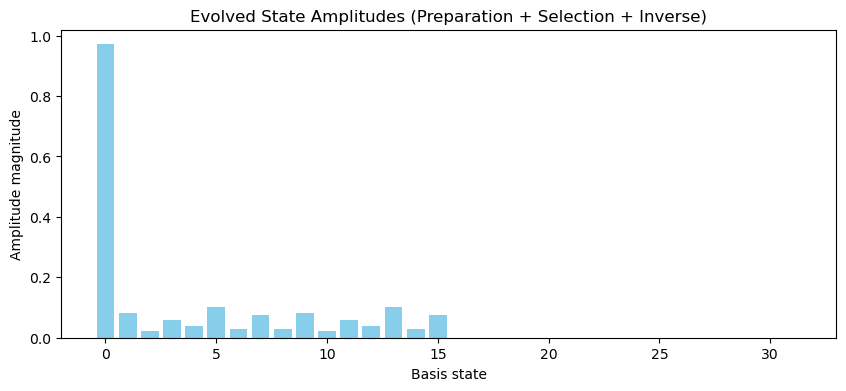

In [3]:
#--------------------------------
# U gate
#--------------------------------


import numpy as np
import math
from scipy.optimize import fsolve
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, XGate, YGate, ZGate, IGate
import itertools
import matplotlib.pyplot as plt

# -------------------------------------------------
# Pad target to next power of 2
# -------------------------------------------------
def pad_target(target):
    N = math.ceil(np.log2(len(target)))
    padded = np.zeros(2**N)
    padded[:len(target)] = target
    return padded, N

# -------------------------------------------------
# Preprocess target into normalized amplitudes
# -------------------------------------------------
def preprocess_target(target):
    total = np.sum(target)
    if total == 0:
        raise ValueError("Target sum is zero")
    betas = np.array([math.sqrt(abs(a) / total) for a in target])
    return betas / np.sum(betas)

# -------------------------------------------------
# Binary-tree amplitudes (limited rotation gates)
# -------------------------------------------------
def psiN_state(theta_vals, N):
    amplitudes = []
    num_amplitudes = 2**N
    for basis_index in range(num_amplitudes):
        binary_path = bin(basis_index)[2:].zfill(N)
        term = 1.0
        node_index = 0
        for bit in binary_path:
            if node_index >= len(theta_vals):
                break
            if bit == "0":
                term *= math.cos(theta_vals[node_index] / 2)
                node_index = 2*node_index + 1
            else:
                term *= math.sin(theta_vals[node_index] / 2)
                node_index = 2*node_index + 2
        amplitudes.append(term)
    return np.array(amplitudes)

# -------------------------------------------------
# System of equations to solve for theta_vals
# -------------------------------------------------
def equations(theta_vals, target):
    psi = psiN_state(theta_vals, math.ceil(np.log2(len(target))))
    return [abs(psi[i]) - abs(target[i]) for i in range(len(target) - 1)]

# -------------------------------------------------
# Preparation circuit with limited rotations
# -------------------------------------------------
def tree_state_prep(theta_vals, target):
    padded_target, N = pad_target(target)
    num_gates_needed = len(target) - 1
    qc = QuantumCircuit(N, name="Preparation")
    node_index = 0

    for target_qubit in range(N):
        for pattern in itertools.product([0, 1], repeat=target_qubit):
            if node_index >= num_gates_needed:
                break
            angle = float(theta_vals[node_index])
            node_index += 1
            if target_qubit == 0:
                qc.ry(angle, target_qubit)
            else:
                ctrl_qubits = list(range(target_qubit-1, -1, -1))
                ctrl_state = "".join(map(str, pattern))
                cry = RYGate(angle).control(num_ctrl_qubits=target_qubit, ctrl_state=ctrl_state)
                qc.append(cry, ctrl_qubits + [target_qubit])
    return qc

# -------------------------------------------------
# Inverse preparation circuit
# -------------------------------------------------
def tree_state_prep_inverse(theta_vals, target):
    padded_target, N = pad_target(target)
    num_gates_needed = len(target) - 1
    qc = QuantumCircuit(N, name="Inverse_Preparation")
    gate_list = []
    node_index = 0

    # Build gate list (same as preparation)
    for target_qubit in range(N):
        for pattern in itertools.product([0,1], repeat=target_qubit):
            if node_index >= num_gates_needed:
                break
            angle = float(theta_vals[node_index])
            if target_qubit == 0:
                g = RYGate(angle)
                qubits = [target_qubit]
            else:
                ctrl_qubits = list(range(target_qubit-1, -1, -1))
                ctrl_state = "".join(map(str, pattern))
                g = RYGate(angle).control(num_ctrl_qubits=target_qubit, ctrl_state=ctrl_state)
                qubits = ctrl_qubits + [target_qubit]
            gate_list.append((g, qubits))
            node_index += 1

    # Apply gates in reverse with negated angles
    for g, qubits in reversed(gate_list):
        if isinstance(g, RYGate):
            qc.ry(-g.params[0], qubits[0])
        else:
            base = RYGate(-g.base_gate.params[0])
            inv_ctrl = base.control(num_ctrl_qubits=g.num_ctrl_qubits, ctrl_state=g.ctrl_state)
            qc.append(inv_ctrl, qubits)
    return qc

# -------------------------------------------------
# Selection block with specific qubits
# -------------------------------------------------
def selection_block_by_qubits(prep_qubits, gate_lists, qubit_lists):
    if len(gate_lists) != len(qubit_lists):
        raise ValueError("gate_lists and qubit_lists must have the same length")

    all_target_qubits = [q for sublist in qubit_lists for q in sublist]
    total_qubits = max(all_target_qubits) + 1
    sel_qc = QuantumCircuit(total_qubits, name="Selection")

    max_patterns = len(gate_lists)
    patterns = [bin(i)[2:].zfill(prep_qubits) for i in range(max_patterns)]

    for idx, (gates, qubits) in enumerate(zip(gate_lists, qubit_lists)):
        ctrl_state = patterns[idx]
        if len(gates) != len(qubits):
            raise ValueError("Number of gates and qubits in this entry must match")
        for g, target in zip(gates, qubits):
            controlled = g.control(num_ctrl_qubits=prep_qubits, ctrl_state=ctrl_state)
            sel_qc.append(controlled, list(range(prep_qubits)) + [target])

    return sel_qc

# -------------------------------------------------
# Main program
# -------------------------------------------------

# def unitary(target_raw, gate_list, qubit_list):
# ...
# return U (circuit prep + select + prep^ad), U^ad
if __name__ == "__main__":
    # Target amplitudes
    target_raw = np.array([0.25, 0.4, 0.2, 0.15, 0.1, 0.4])
    target = preprocess_target(target_raw)
    print("Processed target amplitudes:", target)

    # Solve for rotation angles
    num_angles = len(target) - 1
    initial_guess = np.ones(num_angles) * 0.1
    solution = fsolve(equations, initial_guess, args=(target,))
    print("Solved rotation angles:", solution)

    # Build preparation and inverse preparation circuits
    qc_prep = tree_state_prep(solution, target)
    qc_inv = tree_state_prep_inverse(solution, target)
    N = math.ceil(np.log2(len(target)))
    print("\nPreparation circuit:")
    print(qc_prep.draw(fold=-1))
    print("\nInverse Preparation circuit:")
    print(qc_inv.draw(fold=-1))

    # Example selection block
    prep_qubits = N
    gate_lists =  [
        [XGate()],
        [ZGate()],
     [ZGate(),ZGate()]
    ]
    qubit_lists =[
        [3],
        [3],
        [3,4]
    ]
    sel_block = selection_block_by_qubits(prep_qubits, gate_lists, qubit_lists)
    print("\nSelection block with specific qubits:")
    print(sel_block.draw(fold=-1))

    # Full circuit: Preparation -> Selection -> Inverse
    total_qubits = max(sel_block.num_qubits, prep_qubits)
    full_circuit = QuantumCircuit(total_qubits)
    full_circuit.append(qc_prep.to_instruction(), list(range(prep_qubits)))
    full_circuit.append(sel_block.to_instruction(), list(range(total_qubits)))
    full_circuit.append(qc_inv.to_instruction(), list(range(prep_qubits)))

    # Evolve statevector
    sv_full = Statevector.from_label('0' * total_qubits)
    evolved_full = sv_full.evolve(full_circuit)
    print("\nEvolved statevector after Preparation + Selection + Inverse:")
    print(np.round(evolved_full.data, 4))

    # Plot amplitudes
    plt.figure(figsize=(10,4))
    amplitudes = np.abs(evolved_full.data)
    indices = np.arange(len(amplitudes))
    plt.bar(indices, amplitudes, color='skyblue')
    plt.xlabel('Basis state')
    plt.ylabel('Amplitude magnitude')
    plt.title('Evolved State Amplitudes (Preparation + Selection + Inverse)')
    plt.show()